In [62]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from pybt.tools.plotters import *
from matplotlib.patches import Ellipse, Rectangle
import requests
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ezdxf import recover
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend
from madxtools.plot_tool import *
from pybt.tools.particles import *
from scipy.stats import gaussian_kde

from t12_functions import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

10.706294697042374
gamma = 11.414
beta = 0.996
p = 10.706 GeV/c


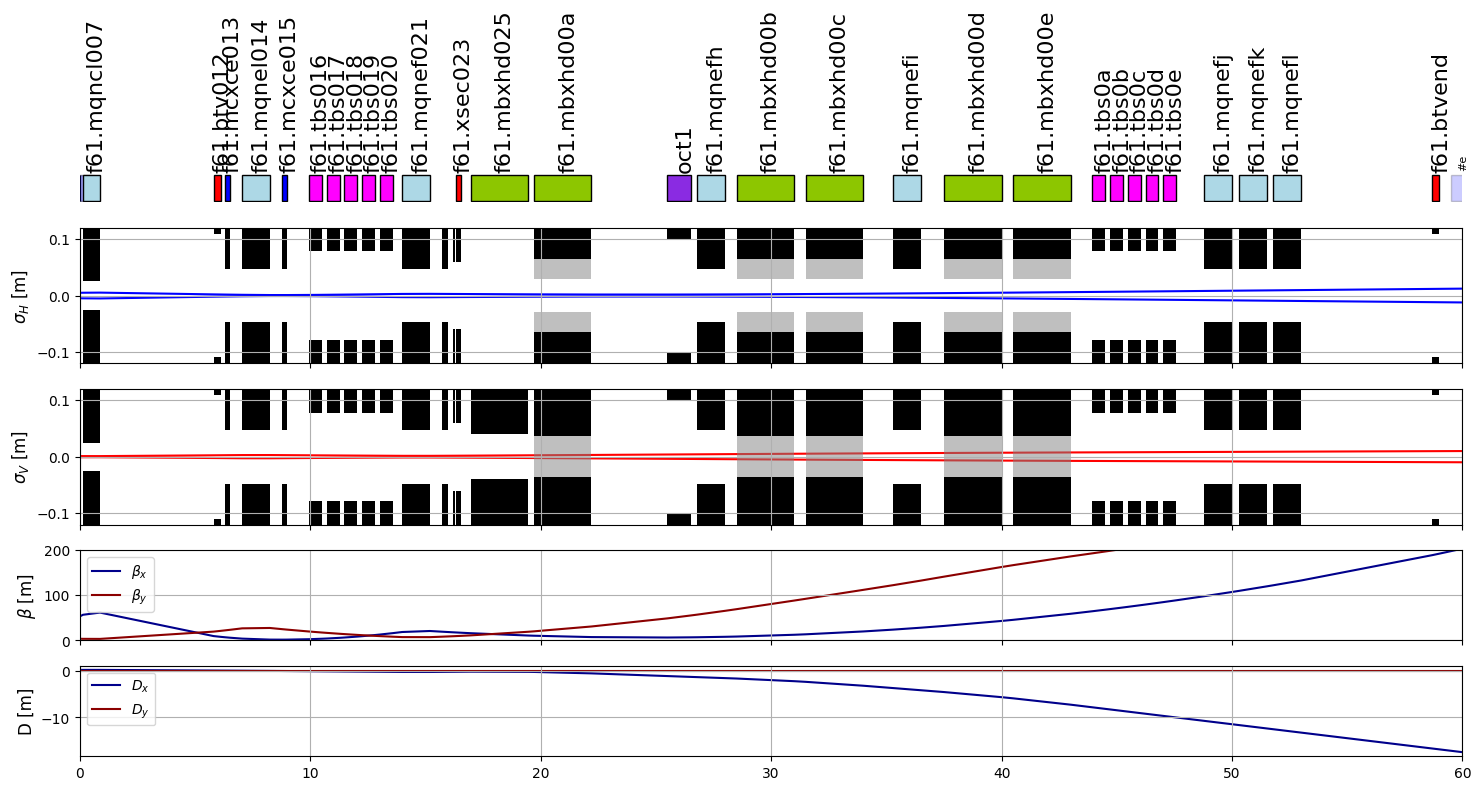

In [63]:
p, exn, eyn, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, ex, ey, sige = calc_initial_condition(2.0)

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("madx_files/f61t12_early.seq")
madx.call("madx_files/f61t12_early.str")

madx.command.beam(particle='PROTON',pc=p,exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
# madx.input('SELECT, FLAG=aperture, COLUMN=apertype;')

madx.input("kQFN1 = "+str(0.4797)+";")
madx.input("kQDN2 = "+str(-0.173)+";")
madx.input("kQFN3 = "+str(0.1986)+";")

# madx.input("kQFN4 = "+str(0.4797)+";")
# madx.input("kQDN5 = "+str(-0.173)+";")
# madx.input("kQFN6 = "+str(0.1986)+";")
# madx.input("kQFN7 = "+str(0.4797)+";")
# madx.input("kQDN8 = "+str(-0.173)+";")

madx.use(sequence="f61t12")
twiss_f61t12 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

plot_graph_with_dispersion(twiss_f61t12, ex, sige, ey, fontsize=12, figsize=(15,8), height_ratios=[1,3,3,2,2])

In [64]:
############################## CREATE PARTICLES DISTRIBUTION ##############################

number_of_particles = 1000
# Random distributionsa
x = np.random.normal(0, 0.03, number_of_particles)
xp = np.random.normal(0, 0.003, number_of_particles)
y = np.random.normal(0, 0.02, number_of_particles)
yp = np.random.normal(0, 0.002, number_of_particles)
pt = np.random.normal(0, sige, number_of_particles)

dist = beam_distrib_norm(alfx0, betx0, ex, number_of_particles, 1)
x = dist[:, 0]
xp = dist[:, 1]
dist = beam_distrib_norm(alfy0, bety0, ey, number_of_particles, 1)
y = dist[:, 0]
yp = dist[:, 1]

init_dist = np.column_stack((x, xp, y, yp, pt))

In [89]:
import scipy.optimize as optimize
import pybobyqa

instrument_focal_point = "oct1"


def optimise(params):
    k_QFN1, k_QDN2, k_QFN3, k3OCT1, k_QFN4 = params
    print(params)
    #################################### Initialize MADX ####################################
    with open('tempfile', 'w') as f:
        madx = Madx(stdout=f,stderr=f)
        madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

    madx.call("madx_files/f61t12_early.seq")
    madx.call("madx_files/f61t12_early.str")

    madx.command.beam(particle='PROTON',pc=p,exn=exn,eyn=eyn)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')


    madx.input("kQFN1 = "+str(k_QFN1)+";")
    madx.input("kQDN2 = "+str(k_QDN2)+";")
    madx.input("kQFN3 = "+str(k_QFN3)+";")

    madx.input("k3OCT1 = "+str(k3OCT1)+";")

    madx.input("kQFN4 = "+str(k_QFN4)+";")


    madx.use(sequence="f61t12")
    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    # PTC
    madx.input('''
    USE, SEQUENCE = f61t12;
    PTC_CREATE_UNIVERSE;
    PTC_CREATE_LAYOUT, MODEL = 1, METHOD = 2, EXACT = FALSE, NST = 4;
    ''')

    for name in twiss.index:
        madx.input(f"PTC_OBSERVE, PLACE = {name};")

    for particle in init_dist:
        madx.input(f'PTC_START, X= {particle[0]}, px={particle[1]}, y={particle[2]}, py={particle[3]}, pt={particle[4]};')
        
    madx.input('''
    PTC_TRACK, TURNS=1, ICASE=5, ELEMENT_BY_ELEMENT=TRUE, DUMP=FALSE, ONETABLE=TRUE, RECLOSS=TRUE, CLOSED_ORBIT=FALSE, MAXAPER={100,100,100,100,100,100};
    PTC_TRACK_END;
    ''')

    ptc_output = madx.table.trackone.dframe()
    ptc_lost = madx.table.trackloss.dframe()

    location = "f61.btvend"
    x = ptc_output.where(ptc_output.s == twiss.loc[location].s).dropna().x
    px = ptc_output.where(ptc_output.s == twiss.loc[location].s).dropna().px
    y = ptc_output.where(ptc_output.s == twiss.loc[location].s).dropna().y
    py = ptc_output.where(ptc_output.s == twiss.loc[location].s).dropna().py
    

    statistic, p_value = kstest(x, 'uniform')
    print(p_value)
    uniform_objective = -(p_value**2)

    objective = len(ptc_lost) + uniform_objective
    
    print (f"OJECTIVE = {objective}")
    return objective


initial_guess = np.array([0.0, -0.1527928, 0.04666728, 0.0, 0.0])

lower = np.array([0.0, -0.221974, 0.0, -10, -0.5])
upper = np.array([0.53823, 0., 0.215518, 10, 0.5])


soln = pybobyqa.solve(optimise, initial_guess, bounds=(lower,upper), rhobeg = 0.0025, seek_global_minimum=False, maxfun=1000)
print(soln)

[ 0.         -0.1527928   0.04666728  0.          0.        ]
0.0
OJECTIVE = 366.0
[ 0.0025     -0.1527928   0.04666728  0.          0.        ]
0.0
OJECTIVE = 365.0
[ 0.         -0.1502928   0.04666728  0.          0.        ]
0.0
OJECTIVE = 364.0
[ 0.         -0.1527928   0.04916728  0.          0.        ]
0.0
OJECTIVE = 351.0
[ 0.         -0.1527928   0.04666728  0.0025      0.        ]
0.0
OJECTIVE = 366.0
[ 0.         -0.1527928   0.04666728  0.          0.0025    ]
0.0
OJECTIVE = 351.0
[ 0.005      -0.1527928   0.04666728  0.          0.        ]
0.0
OJECTIVE = 364.0
[ 0.         -0.1552928   0.04666728  0.          0.        ]
0.0
OJECTIVE = 375.0
[ 0.         -0.1527928   0.04416728  0.          0.        ]
0.0
OJECTIVE = 385.0
[ 0.         -0.1527928   0.04666728 -0.0025      0.        ]
0.0
OJECTIVE = 366.0
[ 0.         -0.1527928   0.04666728  0.         -0.0025    ]
0.0
OJECTIVE = 388.0
[ 1.36336365e-04 -1.52228809e-01  5.06886228e-02 -7.44546175e-20
  1.89706153e-03]
0.0


In [74]:
soln.x

array([ 8.23271517e-03, -1.36543408e-01,  8.28688812e-02,  3.07672533e-16,
        3.56995097e-02])

10.706294697042374
gamma = 11.414
beta = 0.996
p = 10.706 GeV/c


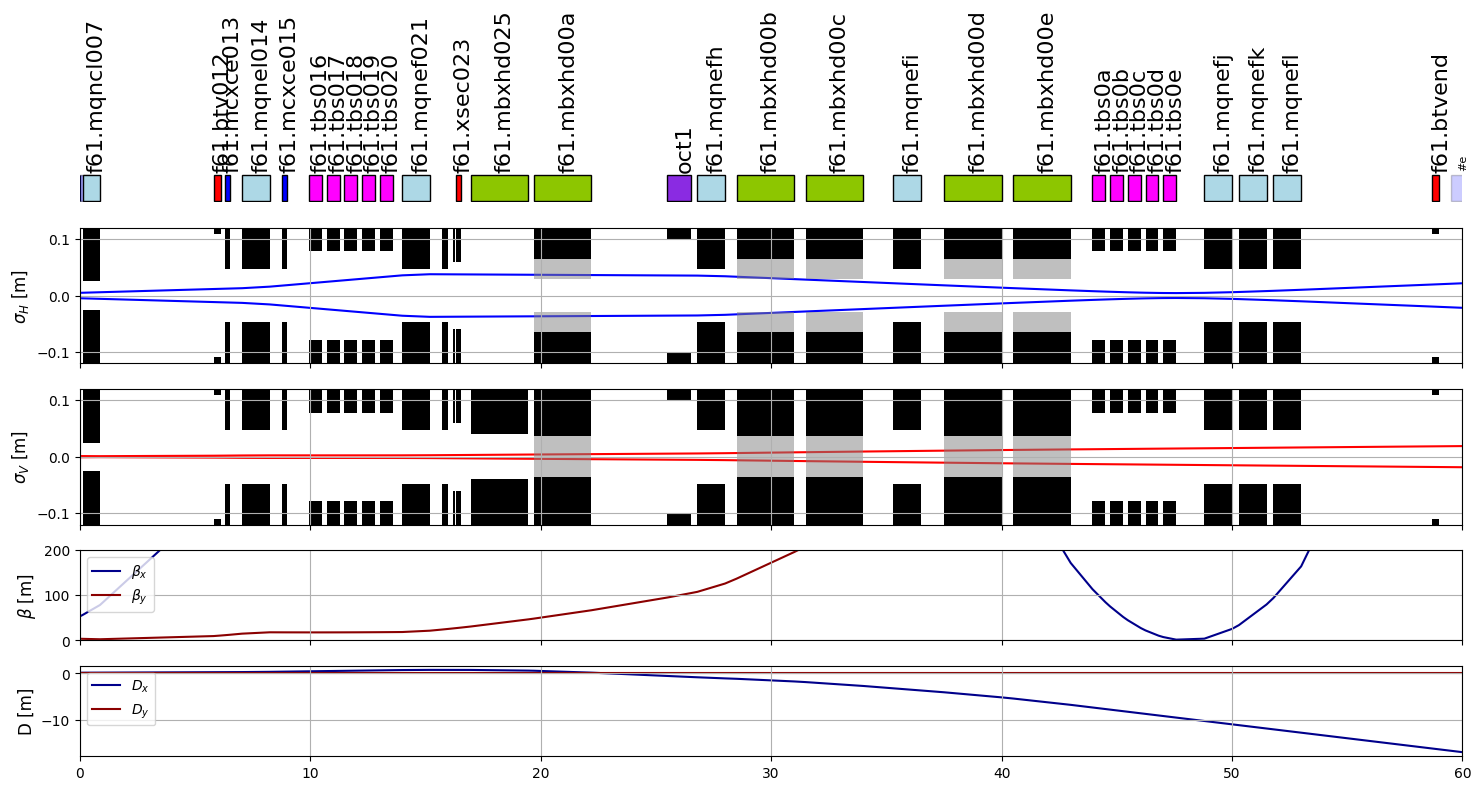

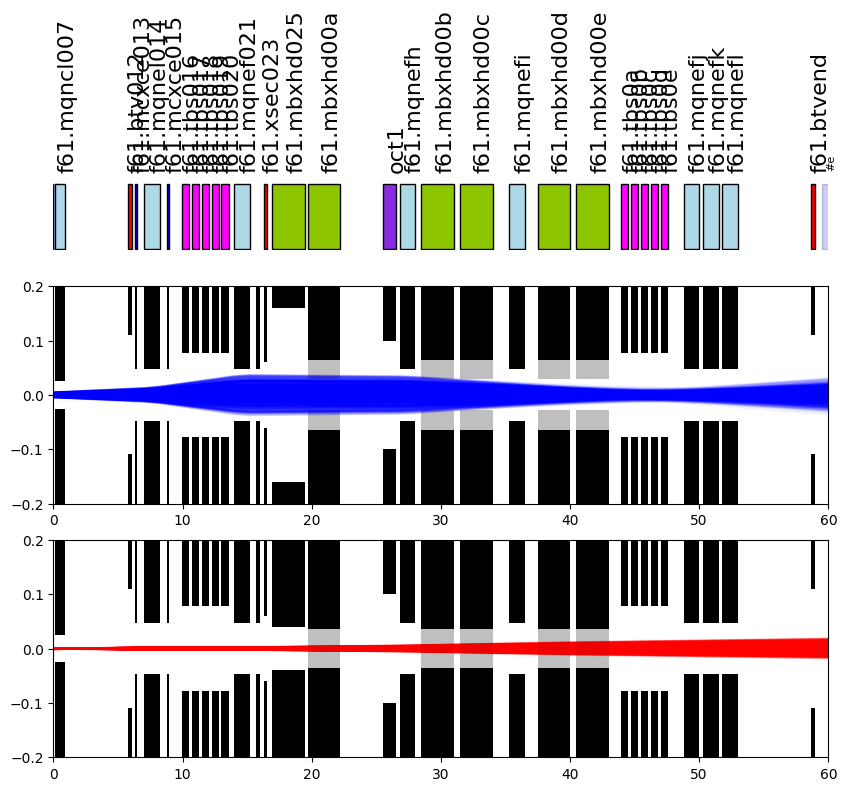

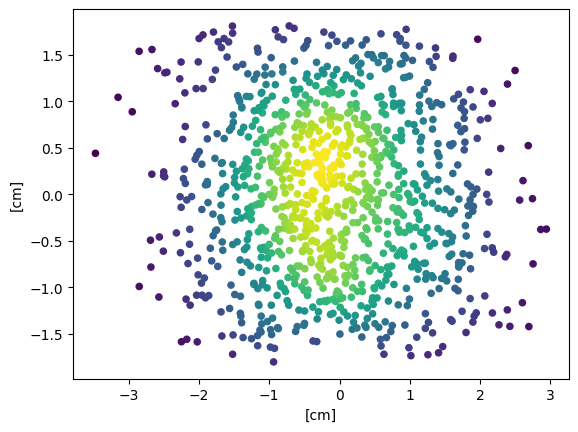

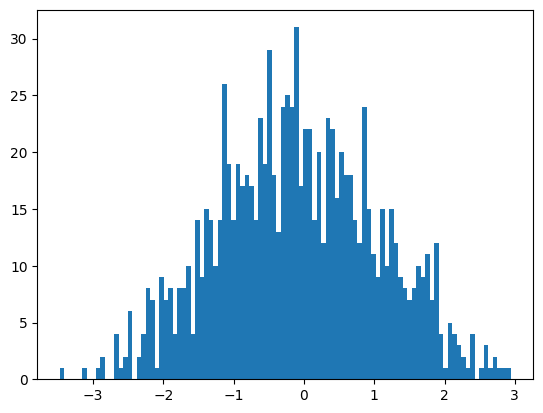

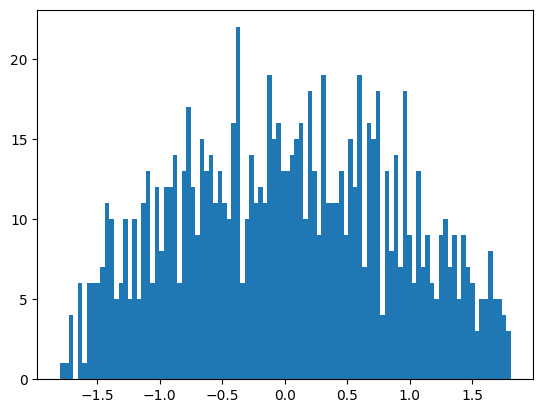

In [81]:
p, exn, eyn, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, ex, ey, sige = calc_initial_condition(2.0)

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("madx_files/f61t12_early.seq")
madx.call("madx_files/f61t12_early.str")

madx.command.beam(particle='PROTON',pc=p,exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input("kQFN1 = "+str(soln.x[0])+";")
madx.input("kQDN2 = "+str(soln.x[1])+";")
madx.input("kQFN3 = "+str(soln.x[2])+";")

madx.input("k3OCT1 = "+str(soln.x[3])+";")

madx.input("kQFN4 = "+str(soln.x[4])+";")


madx.use(sequence="f61t12")
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

plot_graph_with_dispersion(twiss, ex, sige, ey, fontsize=12, figsize=(15,8), height_ratios=[1,3,3,2,2])


madx.input('''
USE, SEQUENCE = f61t12;
PTC_CREATE_UNIVERSE;
PTC_CREATE_LAYOUT, MODEL = 1, METHOD = 2, EXACT = FALSE, NST = 4;
''')

for name in twiss.index:
    madx.input(f"PTC_OBSERVE, PLACE = {name};")

# madx.input("PTC_START, X = 0.03, PX = 0.002, Y = 0.00, PY = 0.000, PT=0.1")
for particle in init_dist:
    madx.input(f'PTC_START, X= {particle[0]}, px={particle[1]}, y={particle[2]}, py={particle[3]}, pt={particle[4]};')
    
madx.input('''
PTC_TRACK, TURNS=1, ICASE=5, ELEMENT_BY_ELEMENT=TRUE, DUMP=FALSE, ONETABLE=TRUE, RECLOSS=TRUE, CLOSED_ORBIT=FALSE, MAXAPER={100,100,100,100,100,100};
PTC_TRACK_END;
''')

ptc_output = madx.table.trackone.dframe()
ptc_lost = madx.table.trackloss.dframe()





fig, ax = plt.subplots(3,1, figsize=(10, 8), height_ratios=[1,2,2])

draw_synoptic(ax[0], twiss)
ax[0].set_xlim(0,twiss.s[-1])
ax[0].set_ylim(-0.01,1.)
ax[0].axis("off")

for i in range(int(number_of_particles)):
    i=i+1

    ax[1].plot(ptc_output[ptc_output.number == i].s, ptc_output[ptc_output.number == i].x, color="b", alpha=0.05)
    ax[2].plot(ptc_output[ptc_output.number == i].s, ptc_output[ptc_output.number == i].y, color="r", alpha=0.05)

draw_aperture_rectcircle(ax[1], ax[2], twiss,"aper_1", "aper_2", "aper_3")
draw_aperture_racetrackH(ax[1], twiss,"aper_1", "aper_2", "aper_3","aper_4")
draw_aperture_circle(ax[1], twiss, "aper_1")
draw_aperture_rectangle(ax[1], twiss, "aper_1")

draw_aperture_racetrackV(ax[2], twiss,"aper_1", "aper_2", "aper_3","aper_4")
draw_aperture_circle(ax[2], twiss, "aper_1")
draw_aperture_rectangle(ax[2], twiss, "aper_2")

ax[1].set_xlim(0,twiss.s[-1])
ax[2].set_xlim(0,twiss.s[-1])
ax[1].set_ylim(-0.2, 0.2)
ax[2].set_ylim(-0.2, 0.2)


location = "f61.btvend"

x = ptc_output.where(ptc_output.s == twiss.loc[location].s).dropna().x
x = np.array(x)*100
px = ptc_output.where(ptc_output.s == twiss.loc[location].s).dropna().px
px = np.array(px)*1000
y = ptc_output.where(ptc_output.s == twiss.loc[location].s).dropna().y
y = np.array(y)*100
py = ptc_output.where(ptc_output.s == twiss.loc[location].s).dropna().py
py = np.array(py)*1000


fig, ax = plt.subplots()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x, y, c=z, s=20)
ax.set_xlabel("[cm]")
ax.set_ylabel("[cm]")


fig, ax = plt.subplots()
ax.hist(x, bins=100);
fig, ax = plt.subplots()
ax.hist(y, bins=100);

In [85]:
import numpy as np
from scipy.stats import kstest

# Example data (replace with your actual data)
data = np.random.rand(1000)  # Assuming you have 1000 data points in [0, 1)

# Perform the Kolmogorov-Smirnov test
statistic, p_value = kstest(x, 'uniform')

# Print the test results
print(f"Kolmogorov-Smirnov statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("The data does not follow a uniform distribution.")
else:
    print("The data follows a uniform distribution.")


Kolmogorov-Smirnov statistic: 0.543
P-value: 9.03439353836935e-277
The data does not follow a uniform distribution.


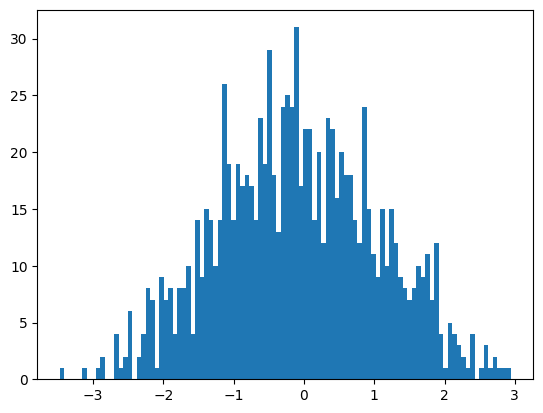

In [86]:
fig, ax = plt.subplots()
ax.hist(x, bins=100);